### Simulation

The previous files hold the symbolic equations of motion that we need to represent the system. Now, we must transform them into Python functions to be able to use in numerical integration. The main objective of the simulations is to analyze the kinematic performance of the system under 3 gravity conditions, i.e., earth's (9.81 m/s²), mars (3.711 m/s²) and moon (1.62 m/s²). Also, we will evaluate the energy consumption of the torques for each gravity condition by multiplying the each torque with its respective coordinate and the simulation time span.

In [1]:
# Loading previous solutions
from equations_of_motion_solution import *

# Import System to integrate EOM using Kane's Method
from pydy.system import System

# Import NumPy functions to setp the numerical values and integrate the equations of motion
from numpy import deg2rad, rad2deg, array, zeros, linspace, shape, ones, transpose

# Import generate_ode_function to transform symbolic equations to numerical functions
from pydy.codegen.ode_function_generators import generate_ode_function

# Import a few functions from Matplotlib.PyPlot
import matplotlib.pyplot as plt

# Import additional needed libraries
from sympy.physics.vector import vlatex
from sympy import init_printing
from IPython.display import Image
init_printing(use_latex='mathjax', pretty_print=False)

Reference frame file loaded
Points and locations file loaded
Inertial properties file loaded


---
#### Variables
Now, we will need to gather the variables, in the equations of motions into lists, i.e. constants, coordinates, speeds and specific inputs.

#### Constants

There are 21 constants in the system:

In [2]:
# Create a list to hold the constants in symbolic form
constants = [lower_arm_length,
             lower_arm_com_length,
             lower_arm_mass,
             lower_arm_inertia,
             upper_arm_length,
             upper_arm_com_length,
             upper_arm_mass,
             upper_arm_inertia,
             hand_length,
             hand_com_length,
             hand_mass,            
             hand_inertia,
             finger1_length,
             finger1_com_length,
             finger1_mass,
             finger1_inertia,
             finger2_length,
             finger2_com_length,
             finger2_mass,
             finger2_inertia,           
             g]
constants

[l_L, d_L, m_L, I_Lz, l_U, d_U, m_U, I_Uz, l_H, d_H, m_H, I_Hz, l_F1, d_F1, m_F1, I_F1z, l_F2, d_F2, m_F2, I_F2z, g]

#### Time varying variables

The states are dependant of the coordinates and speeds. There are 15 varying specified inputs to the system:

In [3]:
# Creathe lists to hold the coordinates, speeds and specified torques in symbolic form
coordinates = [lambda1, lambda2, lambda3, lambda4, lambda5]

speeds = [omega1, omega2, omega3, omega4, omega5]

specifieds = [ground_joint_torque, lower_arm_joint_torque, upper_arm_joint_torque, finger1_joint_torque, finger2_joint_torque]

Create the time array which will be used to integrate the numerical differential equations:

In [4]:
# The time span will be of 0.75 seconds with time points in 60 hz
t = linspace(0, 0.75, 60*0.75)

---
#### Generating the ODE function

The ordinary differential equation integrator scipy.integrate.odeint require a function that numerically evaluates the right hand side of the coupled first order ordinary differential equations. In `mass_matrix` and `forcing_vector` are the symbolic form of the constants and variables. `odeint` function requires the right hand side function, the initial conditions and a time vector. 

In [5]:
# Passing the RHS to the ODE function generator
right_hand_side = generate_ode_function(forcing_vector, coordinates, speeds, constants, mass_matrix=mass_matrix, specifieds=specifieds)

# Setting the speeds and coordinates initial conditions 
x0 = {lambda1: deg2rad(-90),     # Lower arm horizontally oriented
      lambda2: deg2rad(0),
      lambda3: deg2rad(0),
      lambda4: deg2rad(-15),     # Finger 1 slightly inclinated upwards
      lambda5: deg2rad(15),      # Finger 2 slightly inclinated downwards
      omega1: 0.0,
      omega2: 0.0,
      omega3: 0.0,
      omega4: 0.0,
      omega5: 0.0}

Now, we need to specify the numerical value for all constants. To work with realistic values, a 3D CAD geometry was design to model the robot arm. The material of the 4 part robot arm is standard structural steel.

<p align="center">
  <img src="https://user-images.githubusercontent.com/60149913/106359945-340cf380-62ec-11eb-8b14-1b2dfe42aa22.png", width=1032, height=400>
  <img src="https://user-images.githubusercontent.com/60149913/109212270-afe04b80-7785-11eb-82ac-2ff0247af5c7.png", width=500, height=226>
  <img src="https://user-images.githubusercontent.com/60149913/106360135-302da100-62ed-11eb-8fef-fde1e60e99a4.png", width=500, height=226>
  <img src="https://user-images.githubusercontent.com/60149913/106360139-315ece00-62ed-11eb-8c7f-9cdb1302a96c.png", width=500, height=226>
  <img src="https://user-images.githubusercontent.com/60149913/106360140-31f76480-62ed-11eb-9abe-3f68f702a072.png", width=500, height=226>
</p>

---
#### Integrate the equations of motion for each gravity and torque value
To integrate the system, we create a for loop to perform the numerical simulations throughout the gravity and torques vectors. The gravity vector holds the gravity values for the earth, mars and moon, whilist the torque vector holds 3 combination of specified torques for all rigid bodies. 

Note that although there are 21 constants in the system, only 19 values are needed to perform the numerical simulation. The fingers length are not used and the solver may raise an error.

In [6]:
# Create a list holding the gravity values for earth, mars and the moon.
g_values = [9.81, 3.711, 1.62] 

# Create the specified torques list with numerical values
numerical_specifieds = [{ground_joint_torque: lambda lambda1, t: -7644*t**2+4300*ones(shape(t)),    
                        lower_arm_joint_torque: lambda lambda2, t: -1422*t**2+800*ones(shape(t)),
                        upper_arm_joint_torque: lambda lambda3, t: -53*t**2+30*ones(shape(t)),
                        finger1_joint_torque: lambda lambda4, t: -3.55*t**2+1.2*ones(shape(t)),
                        finger2_joint_torque: lambda lambda5, t: -2.66*t**2+1.5*ones(shape(t))},

                        {ground_joint_torque: lambda lambda1, t: -4355.56*t**2+2450*ones(shape(t)), 
                        lower_arm_joint_torque: lambda lambda2, t: -755*t**2+425*ones(shape(t)),
                        upper_arm_joint_torque: lambda lambda3, t: -28.44*t**2+16*ones(shape(t)),
                        finger1_joint_torque: lambda lambda4, t: -0.7111*t**2+0.40*ones(shape(t)),
                        finger2_joint_torque: lambda lambda5, t: -1.4222*t**2+0.80*ones(shape(t))},

                        {ground_joint_torque: lambda lambda1, t: -3022.22*t**2+1700*ones(shape(t)),
                        lower_arm_joint_torque: lambda lambda2, t: -533.33*t**2+300*ones(shape(t)),
                        upper_arm_joint_torque: lambda lambda3, t: -20.44*t**2+11.5*ones(shape(t)),
                        finger1_joint_torque: lambda lambda4, t: -0.5333*t**2+0.30*ones(shape(t)),
                        finger2_joint_torque: lambda lambda5, t: -0.8711*t**2+0.49*ones(shape(t))}]



# Create the solutions list                  
solutions = []

Create the for loop to simulate all the conditions, remembering to ignore the fingers length because the equations don't need these values, otherwise the integration function will raise an error.

In [7]:
for i in range(len(g_values)):

      # Numerical constants
      numerical_constants = {lower_arm_length: 1.0,         # lower_arm_length [m]   
                             lower_arm_com_length: 0.44309, # lower_arm_com_length [m]
                             lower_arm_mass: 347.2,         # lower_arm_mass [kg]
                             lower_arm_inertia: 49.945,     # lower_arm_inertia [kg*m^2]
                             upper_arm_length: 1.62475,     # upper_arm_length [m]
                             upper_arm_com_length: 0.56774, # upper_arm_com_length [m]
                             upper_arm_mass: 61.10,         # upper_arm_mass [kg]
                             upper_arm_inertia: 18.80,      # upper_leg_inertia [kg*m^2]
                             hand_length: 0.6428,           # hand_length [m]
                             hand_com_length: 0.1424,       # hand_com_length [m]
                             hand_mass: 7.33,               # hand_mass [kg]
                             hand_inertia: 0.31035,         # hand_inertia [kg*m^2]
                             #finger1_length: 0.4218,       # finger1_length [m]                Don't matter/Not in the mass or forcing matrices
                             finger1_com_length: 0.2077,    # finger1_com_length [m]
                             finger1_mass: 0.5,             # finger1_mass [kg]
                             finger1_inertia: 0.007322,     # finger1_inertia [kg*m^2]
                             #finger2_length: 0.4218,       # finger2_length [m]                Don't matter/Not in the mass or forcing matrices
                             finger2_com_length: 0.2077,    # finger2_com_length [m]
                             finger2_mass: 0.5,             # finger2_mass [kg]
                             finger2_inertia: 0.007322,     # finger2_inertia [kg*m^2]
                             g: g_values[i]}                # acceleration due to gravity [m/s^2]
      
      for j in range(len(numerical_specifieds)):
                 
            # Integrating the system with the constants, specified and initial condition values
            sys = System(kane,
                        constants=numerical_constants,
                        specifieds=numerical_specifieds[j],
                        initial_conditions=x0,
                        times=t)
                        
            solutions.append(sys.integrate())
            print(f'Simulation (g: {g_values[i]} m/s², torques comb.: {j+1}) completed')

Simulation (g: 9.81 m/s², torques comb.: 1) completed
Simulation (g: 9.81 m/s², torques comb.: 2) completed
Simulation (g: 9.81 m/s², torques comb.: 3) completed
Simulation (g: 3.711 m/s², torques comb.: 1) completed
Simulation (g: 3.711 m/s², torques comb.: 2) completed
Simulation (g: 3.711 m/s², torques comb.: 3) completed
Simulation (g: 1.62 m/s², torques comb.: 1) completed
Simulation (g: 1.62 m/s², torques comb.: 2) completed
Simulation (g: 1.62 m/s², torques comb.: 3) completed


Display the solution array, organized as (combination of gravity and torques, time points, coordinates + velocities). Note that there are 3 torques combinations optimized for each gravity value, therefore the results shoud be qualitatively expected as shown in the matrix below:

<br />

<p align="center">
  <img src="https://user-images.githubusercontent.com/60149913/109576362-fefde780-7ac9-11eb-8690-867960158ef8.png", width=319, height=197>
</p>




In [8]:
# The solution shape is organized as (combination of gravity and torques, time points, coordinates + velocities)
shape(solutions)

(9, 45, 10)

---
#### Plot the specified torques, generalized coordaintes and speeds results

Display:
- Specified torque values optimized for each gravity value;
- Specified torque values for each rigid body;
- Generalized coordinates for each gravity/torque combination;
- Speeds for each gravity/torque combination.

Torques for each gravity plot:

In [9]:
# Create a list with the numerical specified values for the torques (not in as a lambda function)
numerical_specified_plot = [[-7644*t**2+4300*ones(shape(t)),      # Only for the plot
                            -1422*t**2+800*ones(shape(t)),
                            -53*t**2+30*ones(shape(t)),
                            -3.55*t**2+1.2*ones(shape(t)),
                            -2.66*t**2+1.5*ones(shape(t))],
                            [-4355.56*t**2+2450*ones(shape(t)),
                            -755*t**2+425*ones(shape(t)),
                            -28.44*t**2+16*ones(shape(t)), 
                            -0.7111*t**2+0.40*ones(shape(t)),
                            -1.4222*t**2+0.80*ones(shape(t))],
                            [-3022.22*t**2+1700*ones(shape(t)),
                            -533.33*t**2+300*ones(shape(t)),
                            -20.44*t**2+11.5*ones(shape(t)),
                            -0.5333*t**2+0.30*ones(shape(t)),
                            -0.8711*t**2+0.49*ones(shape(t))]]

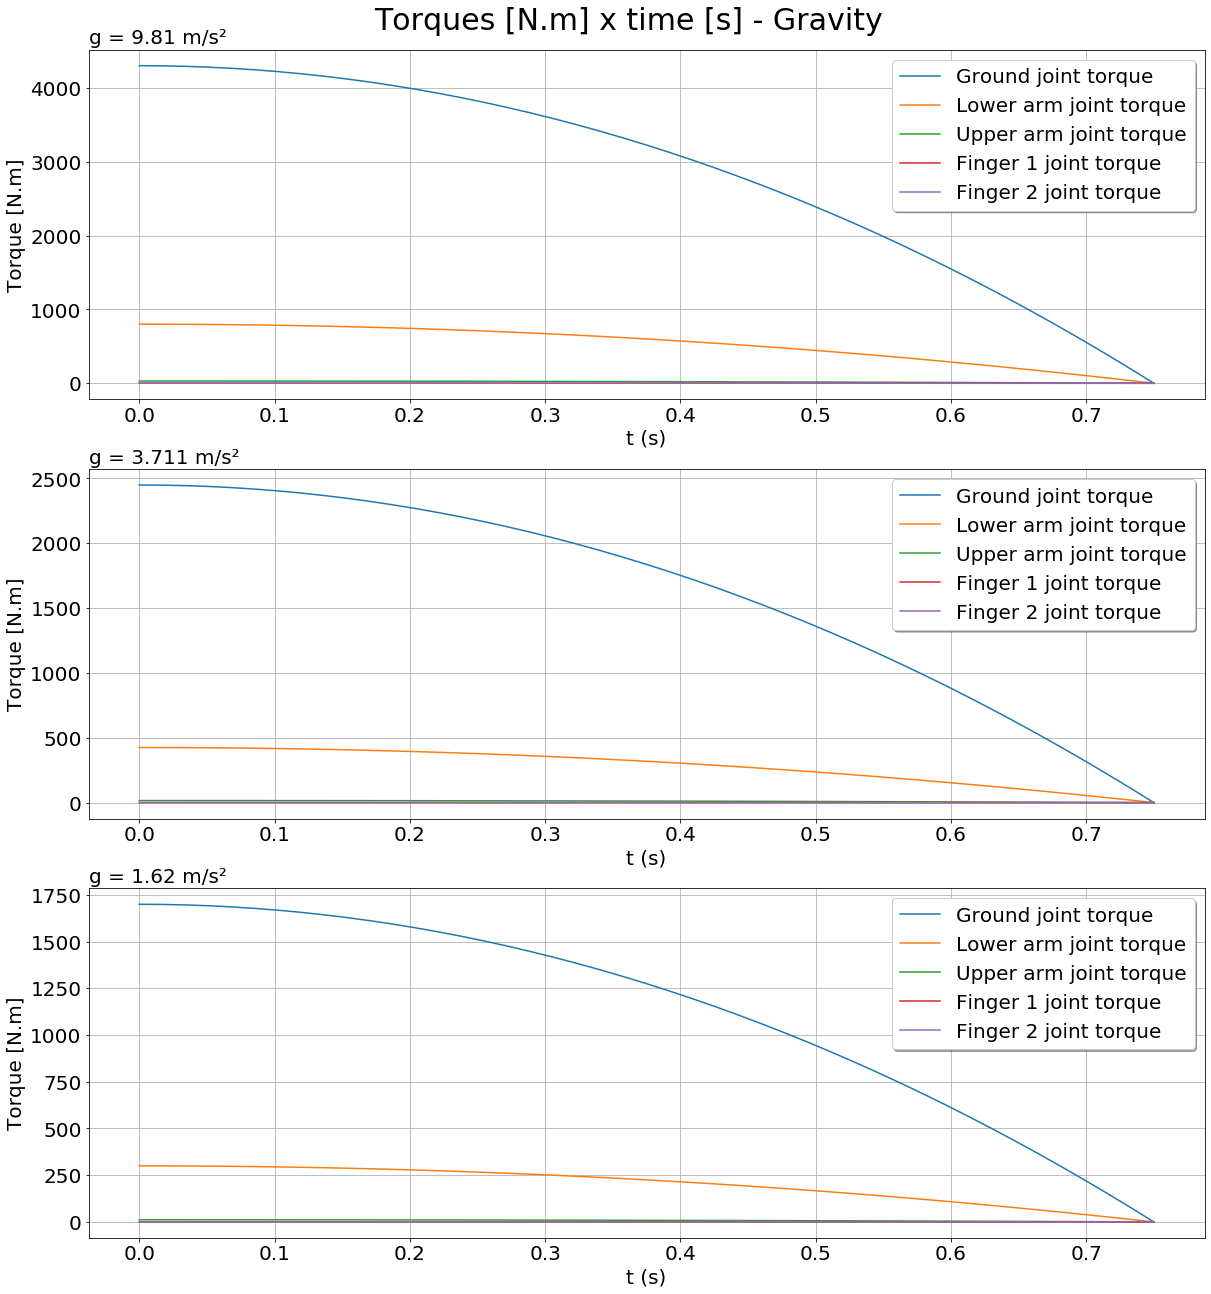

In [10]:
# Plot the specified torques function for each gravity value
%matplotlib inline

fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.set_figheight(20)
fig.set_figwidth(20)
fig.subplots_adjust(top=0.95)
fig.suptitle('Torques [N.m] x time [s] - Gravity', fontsize=30)
labels = ['Ground joint torque', 'Lower arm joint torque', 'Upper arm joint torque', 'Finger 1 joint torque', 'Finger 2 joint torque']

for i in range(shape(numerical_specified_plot[0])[0]):
    ax1.plot(t, transpose(numerical_specified_plot[0][i]), label=labels[i])
    ax1.set_title('g = 9.81 m/s²', fontsize=20, loc='left')
    ax1.set_xlabel('t (s)', fontsize=20)
    ax1.set_ylabel('Torque [N.m]', fontsize=20)
    ax1.grid()
ax1.legend(shadow=True, fancybox=True, fontsize=20)
ax1.tick_params(axis='x', labelsize=20) 
ax1.tick_params(axis='y', labelsize=20) 

for i in range(shape(numerical_specified_plot[1])[0]):
    ax2.plot(t, transpose(numerical_specified_plot[1][i]), label=labels[i])
    ax2.set_title('g = 3.711 m/s²', fontsize=20, loc='left')
    ax2.set_xlabel('t (s)', fontsize=20)
    ax2.set_ylabel('Torque [N.m]', fontsize=20)
    ax2.grid()
ax2.legend(shadow=True, fancybox=True, fontsize=20)
ax2.tick_params(axis='x', labelsize=20) 
ax2.tick_params(axis='y', labelsize=20) 

for i in range(shape(numerical_specified_plot[2])[0]):
    ax3.plot(t, transpose(numerical_specified_plot[2][i]), label=labels[i])
    ax3.set_title('g = 1.62 m/s²', fontsize=20, loc='left')
    ax3.set_xlabel('t (s)', fontsize=20)
    ax3.set_ylabel('Torque [N.m]', fontsize=20)
    ax3.grid()
ax3.legend(shadow=True, fancybox=True, fontsize=20)
ax3.tick_params(axis='x', labelsize=20) 
ax3.tick_params(axis='y', labelsize=20) 

plt.show()

Torques and rigid bodies:

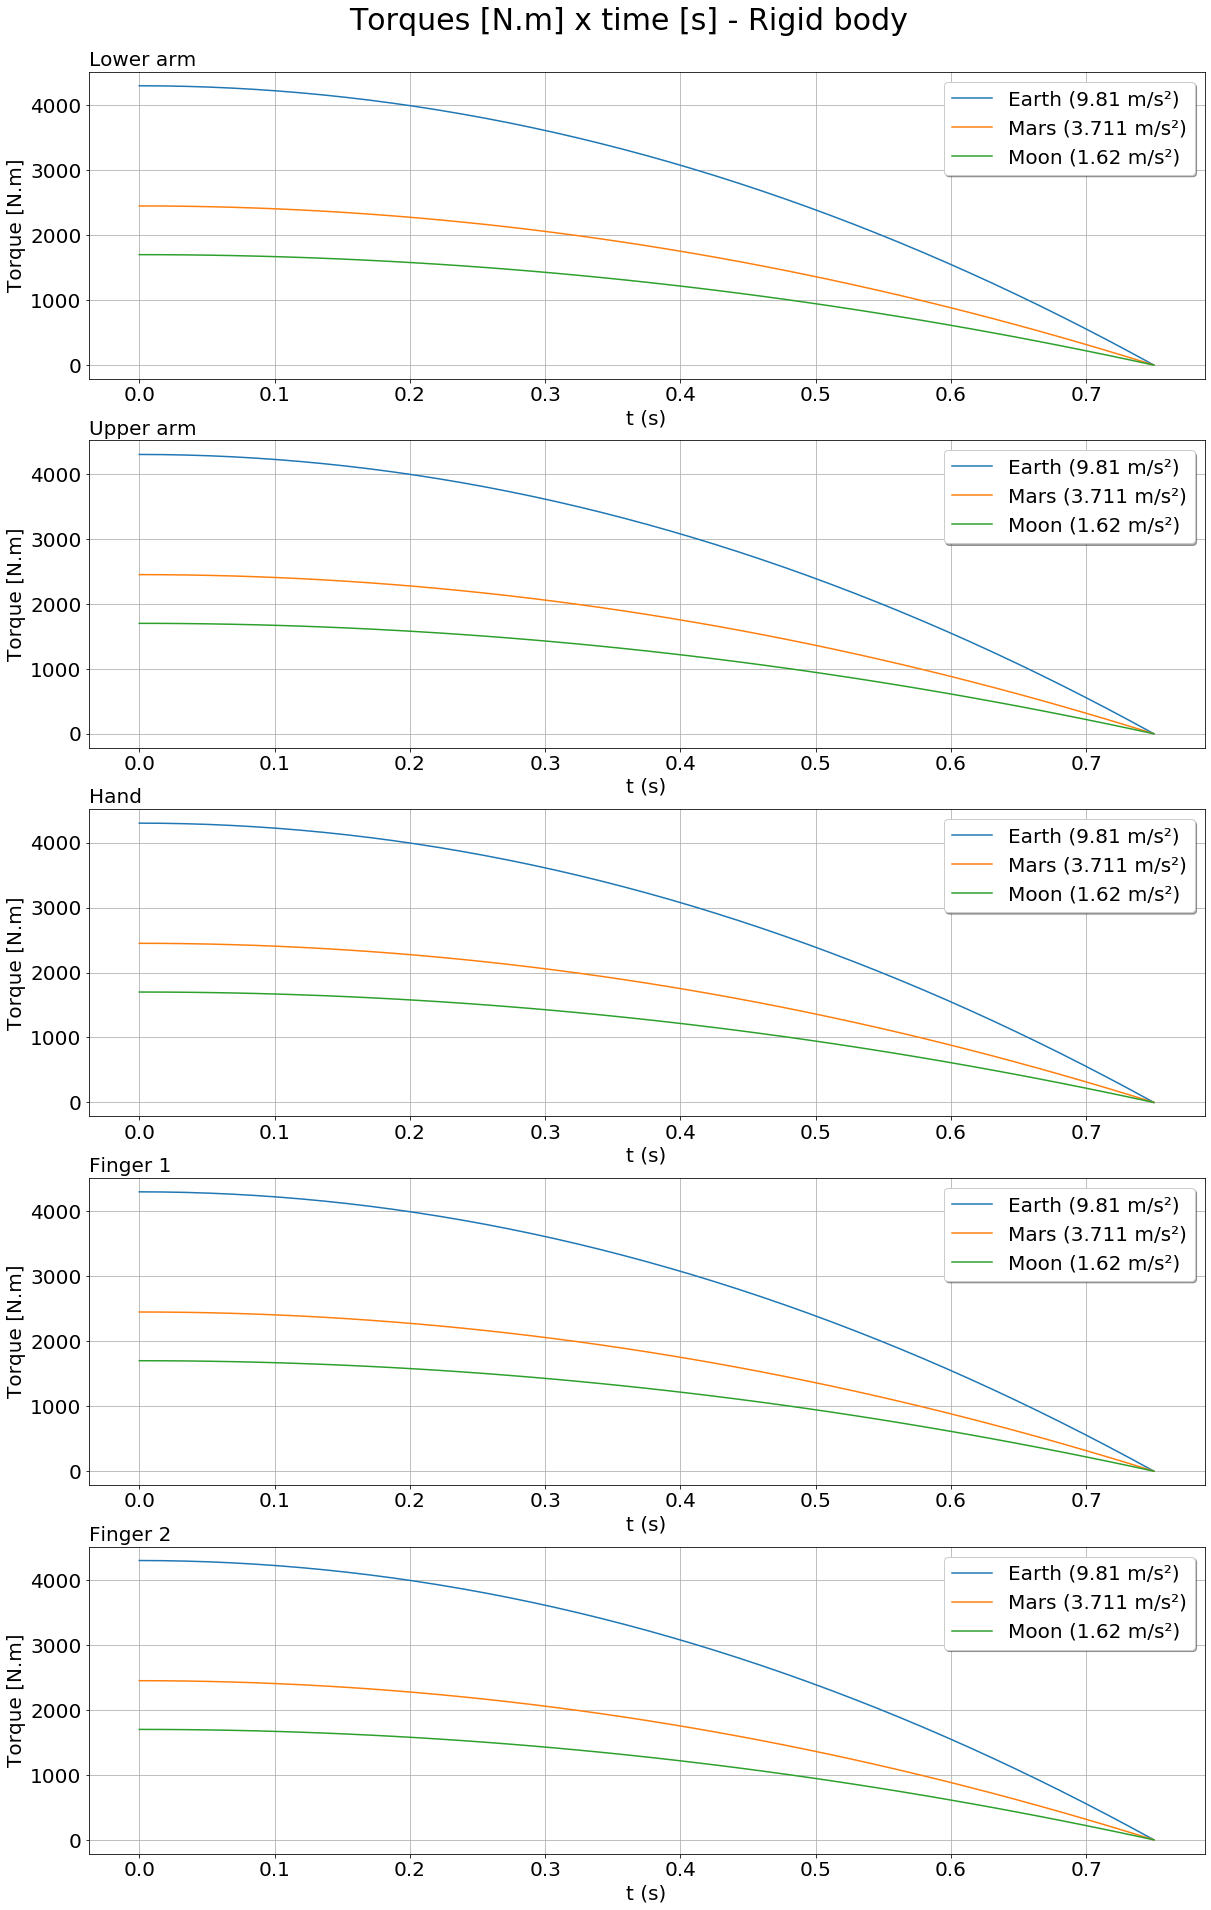

In [11]:
# Plot the torques for each rigid body
%matplotlib inline

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5)
fig.set_figheight(30)
fig.set_figwidth(20)
fig.subplots_adjust(top=0.95)
fig.suptitle('Torques [N.m] x time [s] - Rigid body', fontsize=30)
labels = ['Earth (9.81 m/s²)', 'Mars (3.711 m/s²)', 'Moon (1.62 m/s²)']

for i in range(shape(numerical_specified_plot)[0]):
    ax1.plot(t, transpose(numerical_specified_plot[i][0]), label=labels[i])
    ax1.set_title('Lower arm', fontsize=20, loc='left')
    ax1.set_xlabel('t (s)', fontsize=20)
    ax1.set_ylabel('Torque [N.m]', fontsize=20)
    ax1.grid()
ax1.legend(shadow=True, fancybox=True, fontsize=20)
ax1.tick_params(axis='x', labelsize=20) 
ax1.tick_params(axis='y', labelsize=20) 

for i in range(shape(numerical_specified_plot)[0]):
    ax2.plot(t, transpose(numerical_specified_plot[i][0]), label=labels[i])
    ax2.set_title('Upper arm', fontsize=20, loc='left')
    ax2.set_xlabel('t (s)', fontsize=20)
    ax2.set_ylabel('Torque [N.m]', fontsize=20)
    ax2.grid()
ax2.legend(shadow=True, fancybox=True, fontsize=20)
ax2.tick_params(axis='x', labelsize=20) 
ax2.tick_params(axis='y', labelsize=20) 

for i in range(shape(numerical_specified_plot)[0]):
    ax3.plot(t, transpose(numerical_specified_plot[i][0]), label=labels[i])
    ax3.set_title('Hand', fontsize=20, loc='left')
    ax3.set_xlabel('t (s)', fontsize=20)
    ax3.set_ylabel('Torque [N.m]', fontsize=20)
    ax3.grid()
ax3.legend(shadow=True, fancybox=True, fontsize=20)
ax3.tick_params(axis='x', labelsize=20) 
ax3.tick_params(axis='y', labelsize=20) 

for i in range(shape(numerical_specified_plot)[0]):
    ax4.plot(t, transpose(numerical_specified_plot[i][0]), label=labels[i])
    ax4.set_title('Finger 1', fontsize=20, loc='left')
    ax4.set_xlabel('t (s)', fontsize=20)
    ax4.set_ylabel('Torque [N.m]', fontsize=20)
    ax4.grid()
ax4.legend(shadow=True, fancybox=True, fontsize=20)
ax4.tick_params(axis='x', labelsize=20) 
ax4.tick_params(axis='y', labelsize=20) 

for i in range(shape(numerical_specified_plot)[0]):
    ax5.plot(t, transpose(numerical_specified_plot[i][0]), label=labels[i])
    ax5.set_title('Finger 2', fontsize=20, loc='left')
    ax5.set_xlabel('t (s)', fontsize=20)
    ax5.set_ylabel('Torque [N.m]', fontsize=20)
    ax5.grid()
ax5.legend(shadow=True, fancybox=True, fontsize=20)
ax5.tick_params(axis='x', labelsize=20) 
ax5.tick_params(axis='y', labelsize=20) 

plt.show()

Generalized coordiantes and velocities

In [18]:
shape(solutions)

(9, 45, 10)

In [19]:
# Generalized coordinates
%matplotlib inline

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3)
axes = array([[ax1, ax2, ax3], [ax4, ax5, ax6], [ax7, ax8, ax9]])
fig.set_figheight(30)
fig.set_figwidth(30)
fig.suptitle('Coordinate [deg] x time [s]', fontsize=30)
gravity_labels = ['Earth (9.81 m/s²)', 'Mars (3.711 m/s²)', 'Moon (1.62 m/s²)']
rigid_body_labels = ['Ground joint torque', 'Lower arm joint torque', 'Upper arm joint torque', 'Finger 1 joint torque', 'Finger 2 joint torque']
for i in range(shape(solutions)[0]):
    for j in range(shape(solutions)[1]):
        axes[i,j].plot(t, solutions[i,:,0:5])


for ax in fig.get_axes():
    ax.label_outer()



# Generalized coordinates
plot(t, rad2deg(y[:, :6]))
xlabel('Time [s]')
ylabel('Angle [deg]')
legend(["${}$".format(vlatex(c)) for c in coordinates])

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

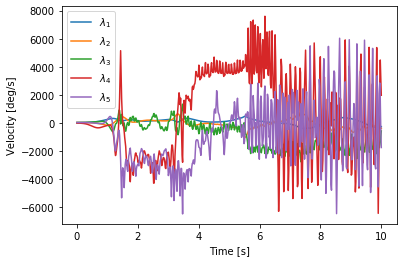

In [41]:
# Velocities
plot(t, rad2deg(y[:, 5:10]))
xlabel('Time [s]')
ylabel('Velocity [deg/s]')
legend(["${}$".format(vlatex(c)) for c in coordinates])